# <span style='color:#0D2BA5'>Projet 5 - Segmentez des clients d'un site e-commerce: Simulation</span>
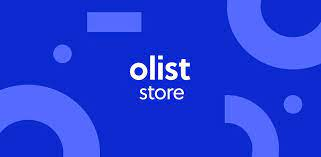

## <span style='background:#33B5FF'>Table des Matieres</span>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:#33B5FF'>1. Introduction</span>



**Mission**
*****
Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.
Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.
Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.




**Source**
*****
Le jeux de donnée est disponible à l'adresse : [Olist Data](https://www.kaggle.com/olistbr/brazilian-ecommerce)
*****



**Axes d'orientations**
*****

Nous allons :
- Réaliser une courte analyse exploratoire.
- Utilisez  des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.
- Différencier les bons et moins bons clients en termes de commandes et de satisfaction.
- Mettre en place une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance.
- Respecter la convention PEP8 pour le code.
- **Conclusions**


## <span style='background:#33B5FF'>2. Bibliothèques d'analyse Python</span>

In [2]:
# Chargement des librairies
import folium
import datetime
from datetime import timedelta
import jyquickhelper
import json

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sys
# Plotly Libraries
import plotly.express as px
import plotly.graph_objects as go
import plotly
# initialize plotly for jupyter notebook
plotly.offline.init_notebook_mode()

# Pré processing
from sklearn.preprocessing import PowerTransformer, StandardScaler, \
    MinMaxScaler

# Clustering
from sklearn.cluster import KMeans

from sklearn import metrics

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
# %pycodestyle_off

import warnings
warnings.filterwarnings('ignore')

# Versions
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + mpl.__version__)
print('Seaborn               : ' + sns.__version__)
print('plotly                : ' + plotly.__version__)
print('folium                : ' + folium.__version__)
print('jyquickhelper         : ' + jyquickhelper.__version__)
#now = datetime.now().isoformat()
#print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.11.3 (main, Apr  7 2023, 19:25:52) [Clang 14.0.0 (clang-1400.0.29.202)]
NumPy                 : 1.24.3
Pandas                : 2.0.1
Matplotlib            : 3.7.1
Seaborn               : 0.12.2
plotly                : 5.14.1
folium                : 0.14.0
jyquickhelper         : 0.4.220


## <span style='background:#33B5FF'>3. Stabilité des clusters au cours du temps</span>

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [41]:
# importer et chargement du fichier
df = pd.read_csv('df_client_nettoyé.csv', sep=',', low_memory=False)

In [42]:
# Afficher les 3 premieres lignes. 
df.head(3)

customer_unique_id customer_city customer_state   
0  0000366f3b9a7992bf8c76cfdf3221e2       cajamar             SP  \
1  0000b849f77a49e4a4ce2b2a4ca5be3f        osasco             SP   
2  0000f46a3911fa3c0805444483337064      sao jose             SC   

   geolocation_lat  geolocation_lng  rfm_recence  rfm_frequence  rfm_montant   
0       -23.335331       -46.828647        112.0            1.0       141.90  \
1       -23.567395       -46.792957        115.0            1.0        27.19   
2       -27.543787       -48.625680        537.0            1.0        86.22   

   note_avis_mean   date_dernier_achat  nbr_commandes  nbr_articles_mean   
0             5.0  2018-05-10 10:56:27              1                1.0  \
1             4.0  2018-05-07 11:11:27              1                1.0   
2             3.0  2017-03-10 21:05:03              1                1.0   

   panier_moyen  echeance_paiement_mean  frais_port_mean moyen_paiement   
0         129.9                     8.0            12.00    credit_card  \
1          18.9                     1.0             8.29    credit_card   
2          69.0                     8.0            17.22    credit_card   

  cat_produit_prefere  
0     cama_mesa_banho  
1        beleza_saude  
2           papelaria

In [43]:
# copie du dataframe de travail
df_stab = df.copy()
df_stab.head(3)

customer_unique_id customer_city customer_state   
0  0000366f3b9a7992bf8c76cfdf3221e2       cajamar             SP  \
1  0000b849f77a49e4a4ce2b2a4ca5be3f        osasco             SP   
2  0000f46a3911fa3c0805444483337064      sao jose             SC   

   geolocation_lat  geolocation_lng  rfm_recence  rfm_frequence  rfm_montant   
0       -23.335331       -46.828647        112.0            1.0       141.90  \
1       -23.567395       -46.792957        115.0            1.0        27.19   
2       -27.543787       -48.625680        537.0            1.0        86.22   

   note_avis_mean   date_dernier_achat  nbr_commandes  nbr_articles_mean   
0             5.0  2018-05-10 10:56:27              1                1.0  \
1             4.0  2018-05-07 11:11:27              1                1.0   
2             3.0  2017-03-10 21:05:03              1                1.0   

   panier_moyen  echeance_paiement_mean  frais_port_mean moyen_paiement   
0         129.9                     8.0            12.00    credit_card  \
1          18.9                     1.0             8.29    credit_card   
2          69.0                     8.0            17.22    credit_card   

  cat_produit_prefere  
0     cama_mesa_banho  
1        beleza_saude  
2           papelaria

In [44]:
# Détermination des dates de référence
# ---------------------------------------------------------------------
# Date de référence de la période complète ?
date_reference = df_stab['date_dernier_achat'].max()
print(f'Data de référence période complète : {date_reference}')
# Data de référence transformée
date_reference = pd.to_datetime(date_reference,
                                format='%Y-%m-%d %H:%M:%S')
# Data de référence de la première période historique - 1 mois
data_ref_1mois = date_reference - pd.DateOffset(months=1)
print(f'Data de référence histo - 1 mois : {data_ref_1mois}')
# Data de référence de la première période historique - 2 mois
data_ref_2mois = date_reference - pd.DateOffset(months=2)
print(f'Data de référence histo - 2 mois : {data_ref_2mois}')
# Data de référence de la première période historique - 3 mois
data_ref_3mois = date_reference - pd.DateOffset(months=3)
print(f'Data de référence histo - 3 mois : {data_ref_3mois}')
# Data de référence de la première période historique - 4 mois
data_ref_4mois = date_reference - pd.DateOffset(months=4)
print(f'Data de référence histo - 4 mois : {data_ref_2mois}')
# Data de référence de la première période historique - 5 mois
data_ref_5mois = date_reference - pd.DateOffset(months=5)
print(f'Data de référence histo - 5 mois : {data_ref_2mois}')
# Data de référence de la première période historique - 6 mois
data_ref_6mois = date_reference - pd.DateOffset(months=6)
print(f'Data de référence histo - 6 mois : {data_ref_6mois}')
# Data de référence de la première période historique - 7 mois
data_ref_7mois = date_reference - pd.DateOffset(months=7)
print(f'Data de référence histo - 7 mois : {data_ref_7mois}')
# Data de référence de la première période historique - 8 mois
data_ref_8mois = date_reference - pd.DateOffset(months=8)
print(f'Data de référence histo - 8 mois : {data_ref_8mois}')
# Data de référence de la première période historique - 9 mois
data_ref_9mois = date_reference - pd.DateOffset(months=9)
print(f'Data de référence histo - 9 mois : {data_ref_9mois}')
# Data de référence de la première période historique - 10 mois
data_ref_10mois = date_reference - pd.DateOffset(months=10)
print(f'Data de référence histo - 10 mois : {data_ref_10mois}')
# Data de référence de la première période historique - 11 mois
data_ref_11mois = date_reference - pd.DateOffset(months=11)
print(f'Data de référence histo - 11 mois : {data_ref_11mois}')
# Data de référence de la première période historique - 1 an
data_ref_12mois = date_reference - pd.DateOffset(months=12)
print(f'Data de référence histo - 1 an : {data_ref_12mois}')

Data de référence période complète : 2018-08-29 15:00:37
Data de référence histo - 1 mois : 2018-07-29 15:00:37
Data de référence histo - 2 mois : 2018-06-29 15:00:37
Data de référence histo - 3 mois : 2018-05-29 15:00:37
Data de référence histo - 4 mois : 2018-06-29 15:00:37
Data de référence histo - 5 mois : 2018-06-29 15:00:37
Data de référence histo - 6 mois : 2018-02-28 15:00:37
Data de référence histo - 7 mois : 2018-01-29 15:00:37
Data de référence histo - 8 mois : 2017-12-29 15:00:37
Data de référence histo - 9 mois : 2017-11-29 15:00:37
Data de référence histo - 10 mois : 2017-10-29 15:00:37
Data de référence histo - 11 mois : 2017-09-29 15:00:37
Data de référence histo - 1 an : 2017-08-29 15:00:37


In [45]:
df_stab.dtypes

customer_unique_id         object
customer_city              object
customer_state             object
geolocation_lat           float64
geolocation_lng           float64
rfm_recence               float64
rfm_frequence             float64
rfm_montant               float64
note_avis_mean            float64
date_dernier_achat         object
nbr_commandes               int64
nbr_articles_mean         float64
panier_moyen              float64
echeance_paiement_mean    float64
frais_port_mean           float64
moyen_paiement             object
cat_produit_prefere        object
dtype: object

In [46]:
# Sélection des variables numériques
cols_num_cat = df_stab.select_dtypes(include=[np.number]).columns.to_list()
# Transformation en logarithme pour avoir le même poids
col_to_log_cat = cols_num_cat[2:11]
col_to_log_cat

['rfm_recence',
 'rfm_frequence',
 'rfm_montant',
 'note_avis_mean',
 'nbr_commandes',
 'nbr_articles_mean',
 'panier_moyen',
 'echeance_paiement_mean',
 'frais_port_mean']


### <span style='background:'>Stabilité K-Means 6 clusters sur 1 an  </span>

**Protocole** :
***
- On conserve un dataframe de référence.
- On sélectionne les clients sur une période historique (ex 1 mois).
- On entraine un algorithme KMeans sur cette période historique ==> les clients sont classés dans des groupes.
- On entraîne un algorithme KMeans sur la période de référence, en ne conservant que les clients présents sur la période historique ==> les clients sont classés dans des groupes.
- On compare les groupes des clients.

In [167]:
# Dataframe de sauvegarde des métriques de stabilité du dataframe
df_resultats_km = pd.DataFrame({})

**Segmentation K-Mean k = 6 selon la période avec les meilleurs hyperparametres**

In [168]:
%pycodestyle_on
def segmentation_kmean_periode(dataframe, dataframe_resutat, date_ref, titre,
                               nb_clusters):
    '''
    Segmentation de clientèle à partir d'une date + métrique de stabilité.
    Parameters
    ----------
    dataframe : dataframe à analyser, obligatoire.
    dataframe_resutat : dataframe de sauvegarde des scores ARI, obligatoire.
    date_ref : date de fin d'analyse de la segmentation avant la date de fin
               d'historique, string au format 'YYYY-MM-DD HH24:MI:SS'.
    titre : titre correspondant à la période de résultat pour le dataframe de
            sauvegarde des scores ARI, obligatoire.
    nb_clusters : nombre de cluster, obligatoire.
    Returns
    -------
    dataframe_resutat : dataframe des sauvegarde des résultats ARI
    df_km : le dataframe de segmentation Kmeans sur la période historique.
    '''

    # ------------------------------------------------------------------------
    # Préparation des dataframes de travail
    # ------------------------------------------------------------------------
    dataframe['date_dernier_achat'] = \
        pd.to_datetime(dataframe['date_dernier_achat'],
                       format='%Y-%m-%d %H:%M:%S')
    df_copie = dataframe.copy()
    # Création des 2 tables de comparaison de la stabilité
    df_hist = \
        df_copie[df_copie['date_dernier_achat'] < date_ref]

    # On garde les clients qui étaient dans la base de données sur la période
    # historique
    df_copie_ref = dataframe.copy()
    df_ref = df_copie_ref[df_copie_ref.customer_unique_id.isin(
        df_hist.customer_unique_id)]

    # Sélection des variables numériques
    cols_num_cat = df_ref.select_dtypes(include=[np.number]).columns.to_list()
    # Transformation en logarithme pour avoir le même poids
    col_to_log_cat = cols_num_cat[2:14]
    df_hist[col_to_log_cat] = df_hist[col_to_log_cat].apply(np.log1p, axis=1)
    df_ref[col_to_log_cat] = df_ref[col_to_log_cat].apply(np.log1p, axis=1)

    # Standardisation StandardScaler - variable transformées en log
    # -----------------------------------------------------------------------
    # Préparation des données
    X_df_hist = df_hist[cols_num_cat].values
    features_df_hist = df_hist[cols_num_cat].columns
    # Standardisation avec StandardScaler (centre, réduit et rend plus la
    # distribution plus normale)
    scaler = StandardScaler()
    X_scaled_hist = scaler.fit_transform(X_df_hist)
    # Dataframe
    X_scaled_hist = pd.DataFrame(X_scaled_hist,
                                 index=df_hist[col_to_log_cat].index,
                                 columns=features_df_hist)
    
    X_df_ref = df_ref[cols_num_cat].values
    features_df_ref = df_ref[cols_num_cat].columns
    # Standardisation avec StandardScaler (centre, réduit et rend plus la
    # distribution plus normale)
    scaler = StandardScaler()
    X_scaled_ref = scaler.fit_transform(X_df_ref)  
    # Dataframe
    X_scaled_ref = pd.DataFrame(X_scaled_ref,
                                index=df_ref[col_to_log_cat].index,
                                columns=features_df_ref)

    # Encodage du moyen de paiement préféré
    encod_paiement = pd.get_dummies(df_hist['moyen_paiement'])
    X_scaled_hist = X_scaled_hist.join(encod_paiement)
    encod_paiement_2 = pd.get_dummies(df_ref['moyen_paiement'])
    X_scaled_ref = X_scaled_ref.join(encod_paiement_2)
    
    # Encodage de la catégorie préférée
    encod_cat_pref = pd.get_dummies(df_hist['cat_produit_prefere'])
    X_scaled_hist = X_scaled_hist.join(encod_cat_pref)
    encod_cat_pref_2 = pd.get_dummies(df_ref['cat_produit_prefere'])
    X_scaled_ref = X_scaled_ref.join(encod_cat_pref_2)
    
    # ------------------------------------------------------------------------
    # Clustering Kmeans sur les 2 périodes historique et de référence
    # ------------------------------------------------------------------------
    # Instanciation de kmeans
    kmeans = KMeans(n_clusters=nb_clusters, 
                    n_init=20,
                    init='k-means++')
    # Entaînement de kmeans sur la période historique
    kmeans.fit(X_scaled_hist)
    kmeans_labels_hist = kmeans.labels_
    X_scaled_hist['Cluster'] = kmeans.labels_
    # Entaînement de sur la période de référence
    kmeans.fit(X_scaled_ref)
    kmeans_labels_ref = kmeans.labels_
    X_scaled_ref['Cluster'] = kmeans.labels_

    # ------------------------------------------------------------------------
    # Scoring ARI de la stabilité
    # ------------------------------------------------------------------------
    # Calcul du score ARI
    ARI_kmeans = metrics.adjusted_rand_score(kmeans_labels_ref,
                                             kmeans_labels_hist)

    # Sauvegarde de l'ARI dans le tableau de résultats
    dataframe_resutat = dataframe_resutat._append(pd.DataFrame({
        'Periode': [titre],
        'Date' : [date_ref],
        'ARI': [ARI_kmeans]}),
        ignore_index=True)

    return dataframe_resutat, X_scaled_hist, X_scaled_ref
%pycodestyle_off

In [169]:
# Score de stabilité ARI sur la période juillet-août 2018 - 1 mois
df_resultats_km, df_hist_1mois, df_ref_1mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_1mois,
                                                   '1 mois_Juillet_août',
                                                   6)

In [170]:
# Score de stabilité ARI sur la période juin-août 2018 - 2 mois
df_resultats_km, df_hist_2mois, df_ref_2mois =segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_2mois,
                                                   '2 mois_Juin_août',
                                                   6)

In [171]:
# Score de stabilité ARI sur la période Avril-août 2018 - 4 mois
df_resultats_km, df_hist_4mois, df_ref_4mois =segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_4mois,
                                                   '4 mois_Avril_août',
                                                   6)

In [172]:
# Score de stabilité ARI sur la période mars-août 2018 - 5 mois
df_resultats_km, df_hist_5mois, df_ref_5mois =segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_5mois,
                                                   '5 mois_Mars_août',
                                                   6)

In [173]:
# Score de stabilité ARI sur la période février-août 2018 - 6 mois
df_resultats_km, df_hist_6mois, df_ref_6mois =segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_6mois,
                                                   '6 mois_Février_août',
                                                   6)

In [174]:
# Score de stabilité ARI sur la période janvier-août 2018 - 7 mois
df_resultats_km, df_hist_7mois, df_ref_7mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_7mois,
                                                   '7 mois_Janvier_août',
                                                    6)

In [175]:
# Score de stabilité ARI sur la période décembre-août 2018 - 8 mois
df_resultats_km, df_hist_8mois, df_ref_8mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_8mois,
                                                   '8 mois_Décembre_août',
                                                   6)

In [176]:
# Score de stabilité ARI sur la période novembre-août 2018 - 9 mois
df_resultats_km, df_hist_9mois, df_ref_9mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_9mois,
                                                   '9 mois_Novembre_août',
                                                   6)

In [177]:
# Score de stabilité ARI sur la période octobre-août 2018 - 10 mois
df_resultats_km, df_hist_10mois, df_ref_10mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_10mois,
                                                   '10 mois_Octobre_août',
                                                   6)

In [178]:
# Score de stabilité ARI sur la période septembre-août 2018 - 11 mois
df_resultats_km, df_hist_11mois, df_ref_11mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_11mois,
                                                   '11 mois_Septembre_août',
                                                   6)

In [179]:
# Score de stabilité ARI sur la période septembre 2017 -août 2018 - 1
df_resultats_km, df_hist_1an, df_ref_1an = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_12mois,
                                                   '1an_aout17_août18',
                                                   6)

In [180]:
df_resultats_km.style.hide()

In [181]:
# Visualisation graphique
plt.figure(figsize=(10, 5))
x = df_resultats_km['Date']
plt.plot(df_resultats_km['Date'], df_resultats_km['ARI'], label='K-Means')
plt.legend()
plt.title('Évolution de la stabilité des clusters KMeans sur 1 an')
plt.xticks(rotation=45, ha='right')

plt.show()

**Conclusion** :
***
- KMeans est relativement stable sur les 3 premiers mois et moins stable pour les derniers mois de l'année.    